<a href="https://colab.research.google.com/github/franlopez1234/7506R-1C2023-GRUPO17/blob/main/7506R_TP1_GRUPO17_CHPX_ENTREGA_ipynb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Librerias

In [1]:
import math
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pandas.plotting import scatter_matrix
from sklearn import tree
from sklearn.compose import make_column_transformer
from sklearn.datasets import make_classification
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (accuracy_score, classification_report,
                             confusion_matrix, f1_score, precision_score,
                             recall_score, make_scorer)

from sklearn.metrics import roc_auc_score
from sklearn.model_selection import GridSearchCV, train_test_split, StratifiedKFold, KFold, RandomizedSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, OrdinalEncoder, StandardScaler
from sklearn.svm import SVC
import seaborn as sns
import sklearn as sk
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)

##Realizamos el tratamiento de las variables

In [2]:
df_hotels_train = pd.read_csv('hotels_train.csv')

In [3]:
df_hotels_train.head(2)

,hotel,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,...,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date,id,is_canceled
0,City Hotel,49,2016,September,37,5,1,2,1,0.0,...,NaN,0,Transient,115.5,0,1,Canceled,2016-08-25,7aa4cc6b-b92c-4061-b21d-4f9e0cac4689,1
1,Resort Hotel,4,2015,October,44,31,0,1,2,0.0,...,NaN,0,Transient,42.0,1,0,Check-Out,2015-11-01,b1428f80-c56c-4ae4-91a9-6962edae08b1,0


In [4]:
#Eliminamos las columnas de reservation_status y reservation_status_date para evitar confusiones
df_hotels_train = df_hotels_train.drop(['reservation_status','reservation_status_date'], axis =1) #->Desmarcar al abrir el archivo
df_hotels_train.dtypes

hotel                              object
lead_time                           int64
arrival_date_year                   int64
arrival_date_month                 object
arrival_date_week_number            int64
arrival_date_day_of_month           int64
stays_in_weekend_nights             int64
stays_in_week_nights                int64
adults                              int64
children                          float64
babies                              int64
meal                               object
country                            object
market_segment                     object
distribution_channel               object
is_repeated_guest                   int64
previous_cancellations              int64
previous_bookings_not_canceled      int64
reserved_room_type                 object
assigned_room_type                 object
booking_changes                     int64
deposit_type                       object
agent                             float64
company                           

In [5]:
df_hotels_train['hotel'] = df_hotels_train['hotel'].astype('string')
df_hotels_train['arrival_date_month'] = df_hotels_train['arrival_date_month'].astype('string')
df_hotels_train['meal'] = df_hotels_train['meal'].astype('string')
df_hotels_train['country'] = df_hotels_train['country'].astype('string')
df_hotels_train['id'] = df_hotels_train['id'].astype('string')
df_hotels_train['customer_type'] = df_hotels_train['customer_type'].astype('string')
df_hotels_train['market_segment'] = df_hotels_train['market_segment'].astype('string')
df_hotels_train['distribution_channel'] = df_hotels_train['distribution_channel'].astype('string')
df_hotels_train['reserved_room_type'] = df_hotels_train['reserved_room_type'].astype('string')
df_hotels_train['assigned_room_type'] = df_hotels_train['assigned_room_type'].astype('string')
df_hotels_train['deposit_type'] = df_hotels_train['deposit_type'].astype('string')

Retiramos los nulos

In [6]:
#Company
df_hotels_train['company'].fillna(-9999, inplace=True)

In [7]:
#Agent
df_hotels_train['agent'].fillna(-9999, inplace=True)

In [8]:
#Country
df_hotels_train['country'].fillna('PRT', inplace=True)

In [9]:
#Children
df_hotels_train['children'].fillna(0, inplace=True)

Analizamos los outliers

In [10]:
#columnas:(lead_time, stays_in_weekend_nights, stays_in_week_nights, adults, children, babies, previous_cancellations, previous_bookings_not_canceled, booking_changes, days_in_waiting_list, required_car_parking_spaces)
media_lead_time=np.mean(df_hotels_train.lead_time)
std_lead_time=np.std(df_hotels_train.lead_time)
df_zscore = pd.DataFrame()
df_zscore['z_lead_time']=(df_hotels_train.lead_time - media_lead_time)/std_lead_time
df_zscore[df_zscore['z_lead_time']>3]


,z_lead_time
15,3.186066
51,3.402834
95,3.086713
426,3.691859
576,4.640223
...,...
61579,3.655731
61695,3.213162
61761,3.466059
61783,3.086713


In [11]:
for i in range(len(df_zscore['z_lead_time'])):
  if df_zscore.z_lead_time[i] > 3:
    df_hotels_train.lead_time[i] = round(media_lead_time)

/var/folders/2g/pz89x6gd4_z44j2mr8rthvmh0000gn/T/ipykernel_2604/3445656125.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_hotels_train.lead_time[i] = round(media_lead_time)


In [12]:
#Normalizamos previus cancellation
for i in range(len(df_hotels_train.previous_cancellations)):
  if df_hotels_train.previous_cancellations[i] > 10:
    df_hotels_train.previous_cancellations[i] = 0 #Redondeamos a 0 ya que no tiene sentido normilazarlos sacando una media

/var/folders/2g/pz89x6gd4_z44j2mr8rthvmh0000gn/T/ipykernel_2604/1879383880.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_hotels_train.previous_cancellations[i] = 0 #Redondeamos a 0 ya que no tiene sentido normilazarlos sacando una media


In [13]:
media_previous_bookings_not_canceled=np.mean(df_hotels_train.previous_bookings_not_canceled)
for i in range(len(df_hotels_train.previous_bookings_not_canceled)):
  if df_hotels_train.previous_bookings_not_canceled[i] > 30:
    df_hotels_train.previous_bookings_not_canceled[i] = round(media_previous_bookings_not_canceled)

/var/folders/2g/pz89x6gd4_z44j2mr8rthvmh0000gn/T/ipykernel_2604/3966743444.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_hotels_train.previous_bookings_not_canceled[i] = round(media_previous_bookings_not_canceled)


In [14]:
#Normalizamos los valores atipicos de booking change
for i in range(len(df_hotels_train.booking_changes)):
  if df_hotels_train.booking_changes[i] > 10:
    df_hotels_train.booking_changes[i] = 0 #Redondeamos a 0 ya que no tiene sentido normilazarlos sacando una media

/var/folders/2g/pz89x6gd4_z44j2mr8rthvmh0000gn/T/ipykernel_2604/3893981792.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_hotels_train.booking_changes[i] = 0 #Redondeamos a 0 ya que no tiene sentido normilazarlos sacando una media


In [15]:
media_days_in_waiting_list = np.mean(df_hotels_train.days_in_waiting_list)

for i in range(len(df_hotels_train.days_in_waiting_list)):
  if df_hotels_train.days_in_waiting_list[i] > 100:
    df_hotels_train.days_in_waiting_list[i] = round(media_days_in_waiting_list)

/var/folders/2g/pz89x6gd4_z44j2mr8rthvmh0000gn/T/ipykernel_2604/3411085939.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_hotels_train.days_in_waiting_list[i] = round(media_days_in_waiting_list)


In [16]:
media_required_car_parking_spaces = np.mean(df_hotels_train.required_car_parking_spaces)

for i in range(len(df_hotels_train.required_car_parking_spaces)):
  if df_hotels_train.required_car_parking_spaces[i] > 7:
    df_hotels_train.required_car_parking_spaces[i] = round(media_required_car_parking_spaces)

/var/folders/2g/pz89x6gd4_z44j2mr8rthvmh0000gn/T/ipykernel_2604/2146687091.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_hotels_train.required_car_parking_spaces[i] = round(media_required_car_parking_spaces)


In [17]:

df_hotels_train.reset_index(drop=True, inplace=True)
for i in range(len(df_hotels_train)):
  if df_hotels_train.adults[i] == 0:
    df_hotels_train = df_hotels_train.drop(index = [i])

df_hotels_train.reset_index(drop=True, inplace=True)

In [18]:
df_hotels_train.reset_index(drop=True, inplace=True)
for i in range(len(df_hotels_train)):
  if df_hotels_train.adults[i] <= 2 and df_hotels_train.babies[i] >= 8:
    df_hotels_train = df_hotels_train.drop(index = [i])
    

df_hotels_train.reset_index(drop=True, inplace=True)

In [19]:
media_adults=np.mean(df_hotels_train.adults)

for i in range(len(df_hotels_train)):
  if df_hotels_train.adults[i] >= 25:
    df_hotels_train.adults[i] = round(media_adults)

/var/folders/2g/pz89x6gd4_z44j2mr8rthvmh0000gn/T/ipykernel_2604/842624944.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_hotels_train.adults[i] = round(media_adults)


In [20]:
df_hotels_train.reset_index(drop=True, inplace=True)

for i in range(len(df_hotels_train)):
  if df_hotels_train.stays_in_week_nights[i] == 0 and df_hotels_train.stays_in_weekend_nights[i] == 0:
    df_hotels_train = df_hotels_train.drop(index = [i])

df_hotels_train.reset_index(drop=True, inplace=True)

Eliminamos id (recordar que la vamos a necesitar mas tarde)

In [21]:
eliminar_columnas = ['id'] # -> Recordar que el id lo vamos a necesitar para machear en kaggle
                                                                      
df_hotels_train.drop(eliminar_columnas, axis='columns', inplace=True)

## Realizamos un encode de las variables

In [22]:
# Realizamos el one hot encoding, con scikit learn.
# Por cada columna a encodear, hacer un fit transform. Dropear la columna, y agregar las columnas nuevas con el nombre adecuado
df_hotels_train_to_encode = df_hotels_train.copy()
cols_a_encodear = ['hotel','arrival_date_month','customer_type','meal', 'distribution_channel','market_segment', 'reserved_room_type', 'assigned_room_type', 'deposit_type', 'country']
ohe = OneHotEncoder(drop='first', handle_unknown='infrequent_if_exist') # Siempre se elimina la primera columna, o el feature entero si solo tiene un valor (no aporta informacion).
transformer = make_column_transformer(
    (ohe, cols_a_encodear),
    remainder='passthrough',
    verbose_feature_names_out=False
)

In [62]:
import joblib
joblib.dump(transformer, "tr.joblib")

['tr.joblib']

Dropeamos "is_canceled" ya que no es necesario encodearla y la guardamos en un dataset para utilizarla mas adelante

In [23]:
df_target = df_hotels_train['is_canceled']
hotels_train_encoded = transformer.fit_transform(df_hotels_train_to_encode.drop('is_canceled', axis=1)) # Se dropea is_canceled, porque no hace falta encodearlo, y ademas la instancia de test no va a tener esa columna.

Encodeamos nuestras variables

In [24]:
df_hotels_train_encoded = pd.DataFrame(
    hotels_train_encoded.toarray(), 
    columns=transformer.get_feature_names_out()
)

#Mostramos las primera 10 columnas de country, ya que el resto tiene una cantidad bajisima de datos y no aportan demasiado
country_cols = df_hotels_train_encoded.columns[df_hotels_train_encoded.columns.str.startswith('country_')]
selected_columns = (df_hotels_train_encoded[country_cols] != 0).sum()
#top_cols = selected_columns.nlargest(10).index
top_cols = ['country_PRT', 'country_GBR', 'country_FRA', 'country_ESP',
       'country_DEU', 'country_ITA', 'country_IRL', 'country_BRA',
       'country_BEL', 'country_USA']
other_countries = [col for col in country_cols if col not in top_cols]
df_hotels_train_encoded['country_other'] = df_hotels_train_encoded[other_countries].sum(axis=1)
df_hotels_train_encoded.drop(other_countries, axis=1, inplace=True)   

Dividimos el data set y copiamos 'is_canceled'

In [25]:
#Creo un dataset con los features que voy a usar para clasificar
df_hotels_train_x = df_hotels_train_encoded

#Creo un dataset con la variable target
df_hotels_train_y = df_hotels_train['is_canceled'].copy()

#Genero los conjuntos de train y test]
x_train, x_test, y_train, y_test = train_test_split(df_hotels_train_x, 
                                                    df_hotels_train_y, 
                                                    test_size=0.3,  #proporcion 70/30
                                                    random_state=2) #semilla

Creamos una funcion para mostrar nuestras metricas

In [26]:
def metricas(y_pred,y_test):

  print(classification_report(y_test,y_pred))
  
  cm = confusion_matrix(y_test,y_pred)
  sns.heatmap(cm, cmap='Blues',annot=True,fmt='g')
  plt.xlabel('Predicted')
  plt.ylabel('True')

##Redes Neuronales

En esta etapa buscaremos crear una red neuronal para predecir nuestras cancelaciones de reserva.
Luego, optimizaremos los hiper parametros para tratar de mejorar su performance

Importamos las librerias

In [27]:
import matplotlib.pyplot as plt
import seaborn as sns

import pandas as pd
import numpy as np

from sklearn.metrics import f1_score,  recall_score, precision_score, accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split


import tensorflow as tf
from tensorflow import keras
from keras.utils.vis_utils import plot_model
np.random.seed(1)
tf.random.set_seed(1) 

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 

2023-05-21 15:30:45.386509: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Escalamos nuestros datos

In [28]:
#Escalamos los datos de train de nuestro data set
scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train)
x_test_scaled = scaler.transform(x_test)

In [29]:
# Calculamos la cantidad de clases
cant_clases = len(np.unique(y_train)) #Nuestro target
d_in = len(x_train.columns) #Parametros de entrenamiento

model_reservas = keras.Sequential([
   keras.layers.Dense(1,input_shape=(d_in,), activation='relu',kernel_initializer='uniform'),
    keras.layers.Dense(1, activation='sigmoid')])


#Mostramos los resultados
model_reservas.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 1)                 81        
                                                                 
 dense_1 (Dense)             (None, 1)                 2         
                                                                 
Total params: 83
Trainable params: 83
Non-trainable params: 0
_________________________________________________________________


2023-05-21 15:31:13.537672: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Compilamos el modelo

In [30]:
y_train.values

array([1, 0, 0, ..., 0, 1, 0])

In [47]:
import keras.backend as K

def f1_score(y_true, y_pred):
  
    # Count positive samples.
    c1 = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    c2 = K.sum(K.round(K.clip(y_pred, 0, 1)))
    c3 = K.sum(K.round(K.clip(y_true, 0, 1)))

    # If there are no true samples, fix the F1 score at 0.
    if c3 == 0:
        return 0.0

    # How many selected items are relevant?
    precision = c1 / (c2 + K.epsilon())

    # How many relevant items are selected?
    recall = c1 / (c3 + K.epsilon())

    # Calculate f1_score
    f1_score = 2 * (precision * recall) / (precision + recall)
    return f1_score

In [49]:
model_reservas.compile(
    optimizer = keras.optimizers.SGD(learning_rate = 0.001), 
    loss = 'binary_crossentropy', #Como mi salida es binaria uso binary_crossentropy

    #Metrica que calcula en cada it 

    metrics = [f1_score]
)

cant_epochs = 100
h_model_reservas = model_reservas.fit(x_train_scaled, y_train, epochs = cant_epochs, batch_size = 16, verbose = False )

In [50]:
y_predic_res = model_reservas.predict(x_test_scaled) #Realizamos el predict

577/577 [==============================] - 0s 480us/step


In [51]:
y_predic_res.shape #Vemos el predict

(18435, 1)

Graficamos la matriz de confusion y mostramos nuestras metricas

577/577 [==============================] - 0s 484us/step
              precision    recall  f1-score   support

           0       0.73      0.85      0.79      7848
           1       0.88      0.76      0.82     10587

    accuracy                           0.80     18435
   macro avg       0.80      0.81      0.80     18435
weighted avg       0.81      0.80      0.80     18435



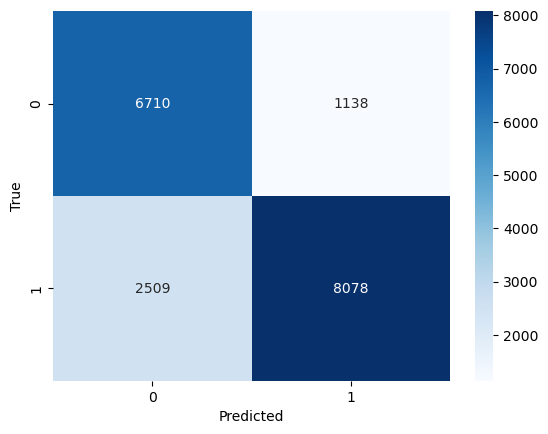

In [52]:
y_predic_ = model_reservas.predict(x_test_scaled)
y_predic_cat = np.where(y_predic_>0.4,1,0) #Seteamos un corte en los datos para determinar si cancelo o no 

ds_validacion=pd.DataFrame(y_predic_cat,y_test).reset_index() #Armamos un dataset
ds_validacion.columns=['y_pred','y_real'] #Nombramos las columnas

metricas(ds_validacion.y_pred,ds_validacion.y_real) #Dividimos el dataset

In [58]:
from sklearn.model_selection import GridSearchCV
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier

# Define a function to build the neural network model with variable epochs
def create_model(epochs=10, num_units=64, learning_rate=0.001):
    model = keras.Sequential([
        keras.layers.Dense(num_units, activation='relu', input_shape=(d_in,)),
        keras.layers.Dense(1, activation='sigmoid')
    ])
    optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Create the KerasClassifier for use in scikit-learn
model = KerasClassifier(build_fn=create_model, batch_size=32, verbose=1)

# Define the hyperparameter grid to search over
param_grid = {
    'epochs': [100],
    'num_units': [64],
    'learning_rate': [0.001, 0.01, 0.1]
}

# Perform grid search with cross-validation
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, n_jobs=6)
grid_result = grid_search.fit(x_train_scaled, y_train)

# Get the best hyperparameters and the best model
best_params = grid_result.best_params_
best_model = grid_result.best_estimator_

# Evaluate the best model on the validation set
val_accuracy = best_model.score(val_data, val_labels)



2023-05-21 18:31:10.950253: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-21 18:31:10.958069: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-21 18:31:10.965697: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable th

Epoch 1/100
Epoch 1/100
Epoch 1/100
Epoch 1/100
Epoch 1/100
Epoch 1/100
1076/1076 [==============================] - 2s 2ms/step - loss: 0.4189 - accuracy: 0.7918
Epoch 2/100
1076/1076 [==============================] - 2s 2ms/step - loss: 0.4289 - accuracy: 0.7843
Epoch 2/100
1076/1076 [==============================] - 2s 2ms/step - loss: 0.4158 - accuracy: 0.7920
Epoch 2/100
1076/1076 [==============================] - 2s 2ms/step - loss: 0.4091 - accuracy: 0.7996
Epoch 2/100
1076/1076 [==============================] - 2s 2ms/step - loss: 0.4133 - accuracy: 0.7946
Epoch 2/100
1076/1076 [==============================] - 2s 2ms/step - loss: 0.3649 - accuracy: 0.8202
Epoch 3/100
1076/1076 [==============================] - 2s 2ms/step - loss: 0.3597 - accuracy: 0.8263
Epoch 3/100
1076/1076 [==============================] - 2s 2ms/step - loss: 0.3600 - accuracy: 0.8227
Epoch 3/100
1076/1076 [==============================] - 2s 2ms/step - loss: 0.3579 - accuracy: 0.8244
Epoch 3/100
1

1076/1076 [==============================] - 2s 2ms/step - loss: 0.3096 - accuracy: 0.8543
Epoch 13/100
1076/1076 [==============================] - 2s 2ms/step - loss: 0.3000 - accuracy: 0.8559
Epoch 13/100
1076/1076 [==============================] - 2s 2ms/step - loss: 0.3027 - accuracy: 0.8555
Epoch 13/100
1076/1076 [==============================] - 2s 2ms/step - loss: 0.2961 - accuracy: 0.8590
Epoch 14/100
1076/1076 [==============================] - 2s 2ms/step - loss: 0.2953 - accuracy: 0.8612
Epoch 14/100
1076/1076 [==============================] - 2s 2ms/step - loss: 0.3072 - accuracy: 0.8548
Epoch 14/100
1076/1076 [==============================] - 2s 2ms/step - loss: 0.3008 - accuracy: 0.8577
Epoch 14/100
1076/1076 [==============================] - 2s 2ms/step - loss: 0.2956 - accuracy: 0.8588
Epoch 14/100
1076/1076 [==============================] - 2s 2ms/step - loss: 0.2918 - accuracy: 0.8619
Epoch 15/100
1076/1076 [==============================] - 2s 2ms/step - loss:

1076/1076 [==============================] - 3s 2ms/step - loss: 0.2798 - accuracy: 0.8687
Epoch 24/100
1076/1076 [==============================] - 2s 2ms/step - loss: 0.2760 - accuracy: 0.8707
Epoch 25/100
1076/1076 [==============================] - 2s 2ms/step - loss: 0.2851 - accuracy: 0.8680
Epoch 25/100
1076/1076 [==============================] - 2s 2ms/step - loss: 0.2775 - accuracy: 0.8693
Epoch 25/100
1076/1076 [==============================] - 2s 2ms/step - loss: 0.2826 - accuracy: 0.8684
Epoch 25/100
1076/1076 [==============================] - 2s 2ms/step - loss: 0.2777 - accuracy: 0.8699
Epoch 25/100
1076/1076 [==============================] - 2s 2ms/step - loss: 0.2774 - accuracy: 0.8711
Epoch 26/100
1076/1076 [==============================] - 2s 2ms/step - loss: 0.2803 - accuracy: 0.8705
Epoch 26/100
1076/1076 [==============================] - 2s 2ms/step - loss: 0.2765 - accuracy: 0.8700
Epoch 26/100
1076/1076 [==============================] - 2s 2ms/step - loss:

1076/1076 [==============================] - 2s 2ms/step - loss: 0.2733 - accuracy: 0.8758
Epoch 36/100
1076/1076 [==============================] - 2s 2ms/step - loss: 0.2646 - accuracy: 0.8771
Epoch 36/100
1076/1076 [==============================] - 2s 2ms/step - loss: 0.2657 - accuracy: 0.8775
Epoch 37/100
1076/1076 [==============================] - 2s 2ms/step - loss: 0.2646 - accuracy: 0.8777
Epoch 37/100
1076/1076 [==============================] - 2s 2ms/step - loss: 0.2712 - accuracy: 0.8770
Epoch 37/100
1076/1076 [==============================] - 2s 2ms/step - loss: 0.2699 - accuracy: 0.8743
Epoch 37/100
1076/1076 [==============================] - 2s 2ms/step - loss: 0.2666 - accuracy: 0.8758
Epoch 37/100
1076/1076 [==============================] - 2s 2ms/step - loss: 0.2656 - accuracy: 0.8769
Epoch 38/100
1076/1076 [==============================] - 2s 2ms/step - loss: 0.2638 - accuracy: 0.8774
Epoch 38/100
1076/1076 [==============================] - 2s 2ms/step - loss:

1076/1076 [==============================] - 2s 2ms/step - loss: 0.2631 - accuracy: 0.8806
Epoch 47/100
1076/1076 [==============================] - 2s 2ms/step - loss: 0.2616 - accuracy: 0.8795
Epoch 47/100
1076/1076 [==============================] - 2s 2ms/step - loss: 0.2569 - accuracy: 0.8809
Epoch 47/100
1076/1076 [==============================] - 2s 2ms/step - loss: 0.2576 - accuracy: 0.8804
Epoch 48/100
1076/1076 [==============================] - 2s 2ms/step - loss: 0.2570 - accuracy: 0.8812
Epoch 48/100
1076/1076 [==============================] - 2s 2ms/step - loss: 0.2585 - accuracy: 0.8796
Epoch 47/100
1076/1076 [==============================] - 2s 2ms/step - loss: 0.2592 - accuracy: 0.8817
Epoch 48/100
1076/1076 [==============================] - 2s 2ms/step - loss: 0.2609 - accuracy: 0.8791
Epoch 48/100
1076/1076 [==============================] - 2s 2ms/step - loss: 0.2563 - accuracy: 0.8801
Epoch 48/100
1076/1076 [==============================] - 2s 2ms/step - loss:

1076/1076 [==============================] - 2s 2ms/step - loss: 0.2547 - accuracy: 0.8821
Epoch 59/100
1076/1076 [==============================] - 2s 2ms/step - loss: 0.2489 - accuracy: 0.8847
Epoch 59/100
1076/1076 [==============================] - 2s 2ms/step - loss: 0.2488 - accuracy: 0.8847
Epoch 60/100
1076/1076 [==============================] - 2s 2ms/step - loss: 0.2528 - accuracy: 0.8841
Epoch 59/100
1076/1076 [==============================] - 2s 2ms/step - loss: 0.2545 - accuracy: 0.8838
Epoch 60/100
1076/1076 [==============================] - 2s 2ms/step - loss: 0.2516 - accuracy: 0.8841
Epoch 61/100
1076/1076 [==============================] - 2s 2ms/step - loss: 0.2478 - accuracy: 0.8863
Epoch 60/100
1076/1076 [==============================] - 2s 2ms/step - loss: 0.2492 - accuracy: 0.8854
Epoch 61/100
1076/1076 [==============================] - 2s 2ms/step - loss: 0.2553 - accuracy: 0.8829
Epoch 61/100
1076/1076 [==============================] - 2s 2ms/step - loss:

1076/1076 [==============================] - 2s 2ms/step - loss: 0.2471 - accuracy: 0.8864
Epoch 70/100
1076/1076 [==============================] - 2s 2ms/step - loss: 0.2467 - accuracy: 0.8879
Epoch 72/100
1076/1076 [==============================] - 2s 2ms/step - loss: 0.2494 - accuracy: 0.8841
Epoch 71/100
1076/1076 [==============================] - 2s 2ms/step - loss: 0.2444 - accuracy: 0.8861
Epoch 72/100
1076/1076 [==============================] - 2s 2ms/step - loss: 0.2425 - accuracy: 0.8884
Epoch 71/100
1076/1076 [==============================] - 2s 2ms/step - loss: 0.2622 - accuracy: 0.8856
Epoch 72/100
1076/1076 [==============================] - 2s 2ms/step - loss: 0.2466 - accuracy: 0.8857
Epoch 71/100
1076/1076 [==============================] - 2s 2ms/step - loss: 0.2448 - accuracy: 0.8873
Epoch 73/100
1076/1076 [==============================] - 2s 2ms/step - loss: 0.2456 - accuracy: 0.8873
Epoch 73/100
1076/1076 [==============================] - 2s 2ms/step - loss:

1076/1076 [==============================] - 2s 2ms/step - loss: 0.2483 - accuracy: 0.8877
Epoch 83/100
1076/1076 [==============================] - 2s 2ms/step - loss: 0.2405 - accuracy: 0.8903
Epoch 84/100
1076/1076 [==============================] - 2s 2ms/step - loss: 0.2431 - accuracy: 0.8897
Epoch 82/100
1076/1076 [==============================] - 2s 2ms/step - loss: 0.2393 - accuracy: 0.8897
Epoch 84/100
1076/1076 [==============================] - 2s 2ms/step - loss: 0.2382 - accuracy: 0.8902
Epoch 83/100
1076/1076 [==============================] - 2s 2ms/step - loss: 0.2434 - accuracy: 0.8901
Epoch 83/100
1076/1076 [==============================] - 2s 2ms/step - loss: 0.2479 - accuracy: 0.8893
Epoch 84/100
1076/1076 [==============================] - 2s 2ms/step - loss: 0.2406 - accuracy: 0.8912
Epoch 85/100
1076/1076 [==============================] - 2s 2ms/step - loss: 0.2418 - accuracy: 0.8895
Epoch 83/100
1076/1076 [==============================] - 2s 2ms/step - loss:

1076/1076 [==============================] - 2s 2ms/step - loss: 0.2400 - accuracy: 0.8909
Epoch 94/100
1076/1076 [==============================] - 2s 2ms/step - loss: 0.2365 - accuracy: 0.8922
Epoch 96/100
1076/1076 [==============================] - 2s 2ms/step - loss: 0.2351 - accuracy: 0.8939
Epoch 96/100
1076/1076 [==============================] - 2s 2ms/step - loss: 0.2338 - accuracy: 0.8932
Epoch 95/100
1076/1076 [==============================] - 2s 2ms/step - loss: 0.2396 - accuracy: 0.8911
Epoch 96/100
1076/1076 [==============================] - 2s 2ms/step - loss: 0.2393 - accuracy: 0.8918
Epoch 95/100
1076/1076 [==============================] - 2s 2ms/step - loss: 0.2360 - accuracy: 0.8913
Epoch 97/100
1076/1076 [==============================] - 2s 2ms/step - loss: 0.2348 - accuracy: 0.8932
Epoch 97/100
1076/1076 [==============================] - 2s 2ms/step - loss: 0.2383 - accuracy: 0.8906
Epoch 95/100
1076/1076 [==============================] - 2s 2ms/step - loss:

1076/1076 [==============================] - 2s 2ms/step - loss: 0.5801 - accuracy: 0.7175
Epoch 5/100
1076/1076 [==============================] - 2s 2ms/step - loss: 0.3272 - accuracy: 0.8418
Epoch 7/100
1076/1076 [==============================] - 2s 2ms/step - loss: 0.3310 - accuracy: 0.8421
Epoch 6/100
1076/1076 [==============================] - 2s 2ms/step - loss: 0.3355 - accuracy: 0.8362
Epoch 6/100
1076/1076 [==============================] - 2s 2ms/step - loss: 0.3230 - accuracy: 0.8462
Epoch 8/100
1076/1076 [==============================] - 2s 2ms/step - loss: 0.5350 - accuracy: 0.7590
Epoch 6/100
1076/1076 [==============================] - 2s 2ms/step - loss: 0.3273 - accuracy: 0.8417
Epoch 7/100
1076/1076 [==============================] - 2s 2ms/step - loss: 0.3291 - accuracy: 0.8421
Epoch 7/100
1076/1076 [==============================] - 2s 2ms/step - loss: 0.3178 - accuracy: 0.8489
Epoch 9/100
1076/1076 [==============================] - 2s 2ms/step - loss: 0.5159 -

1076/1076 [==============================] - 2s 2ms/step - loss: 0.2861 - accuracy: 0.8680
Epoch 22/100
1076/1076 [==============================] - 2s 2ms/step - loss: 0.8169 - accuracy: 0.6794
Epoch 20/100
1076/1076 [==============================] - 2s 2ms/step - loss: 0.2862 - accuracy: 0.8655
Epoch 21/100
1076/1076 [==============================] - 2s 2ms/step - loss: 0.2890 - accuracy: 0.8650
Epoch 21/100
1076/1076 [==============================] - 2s 2ms/step - loss: 0.2863 - accuracy: 0.8684
Epoch 23/100
1076/1076 [==============================] - 2s 2ms/step - loss: 0.6014 - accuracy: 0.6762
Epoch 21/100
1076/1076 [==============================] - 2s 2ms/step - loss: 0.2883 - accuracy: 0.8670
Epoch 23/100
1076/1076 [==============================] - 2s 2ms/step - loss: 0.2848 - accuracy: 0.8668
Epoch 22/100
1076/1076 [==============================] - 2s 2ms/step - loss: 0.2895 - accuracy: 0.8652
Epoch 22/100
1076/1076 [==============================] - 2s 2ms/step - loss:

1076/1076 [==============================] - 2s 2ms/step - loss: 0.2727 - accuracy: 0.8749
Epoch 35/100
1076/1076 [==============================] - 2s 2ms/step - loss: 0.2740 - accuracy: 0.8719
Epoch 35/100
1076/1076 [==============================] - 2s 2ms/step - loss: 0.2681 - accuracy: 0.8752
Epoch 34/100
1076/1076 [==============================] - 2s 2ms/step - loss: 0.7682 - accuracy: 0.6691
Epoch 33/100
1076/1076 [==============================] - 2s 2ms/step - loss: 0.4439 - accuracy: 0.7830
Epoch 6/100
1076/1076 [==============================] - 2s 2ms/step - loss: 0.2704 - accuracy: 0.8732
Epoch 34/100
1076/1076 [==============================] - 2s 2ms/step - loss: 0.2709 - accuracy: 0.8749
Epoch 36/100
1076/1076 [==============================] - 2s 2ms/step - loss: 0.2766 - accuracy: 0.8730
Epoch 36/100
1076/1076 [==============================] - 2s 2ms/step - loss: 0.2690 - accuracy: 0.8759
Epoch 35/100
1076/1076 [==============================] - 2s 2ms/step - loss: 

1076/1076 [==============================] - 2s 2ms/step - loss: 0.2609 - accuracy: 0.8807
Epoch 47/100
1076/1076 [==============================] - 2s 2ms/step - loss: 0.2595 - accuracy: 0.8813
Epoch 48/100
1076/1076 [==============================] - 2s 2ms/step - loss: 0.5594 - accuracy: 0.6755
Epoch 18/100
1076/1076 [==============================] - 2s 2ms/step - loss: 10.0510 - accuracy: 0.6760
Epoch 45/100
1076/1076 [==============================] - 2s 2ms/step - loss: 0.2599 - accuracy: 0.8800
Epoch 46/100
1076/1076 [==============================] - 2s 2ms/step - loss: 0.2615 - accuracy: 0.8796
Epoch 48/100
1076/1076 [==============================] - 2s 2ms/step - loss: 0.2580 - accuracy: 0.8814
Epoch 47/100
1076/1076 [==============================] - 2s 2ms/step - loss: 0.5499 - accuracy: 0.6688
Epoch 19/100
1076/1076 [==============================] - 2s 2ms/step - loss: 1.2134 - accuracy: 0.6764
Epoch 47/100
Epoch 46/100
1076/1076 [==============================] - 2s 2m

1076/1076 [==============================] - 2s 2ms/step - loss: 0.2537 - accuracy: 0.8834
Epoch 57/100
1076/1076 [==============================] - 2s 2ms/step - loss: 0.8042 - accuracy: 0.6715
Epoch 56/100
1076/1076 [==============================] - 2s 2ms/step - loss: 0.2657 - accuracy: 0.8822
Epoch 58/100
1076/1076 [==============================] - 2s 2ms/step - loss: 0.2532 - accuracy: 0.8828
Epoch 59/100
1076/1076 [==============================] - 2s 2ms/step - loss: 0.2475 - accuracy: 0.8874
Epoch 60/100
1076/1076 [==============================] - 2s 2ms/step - loss: 0.2548 - accuracy: 0.8840
Epoch 58/100
1076/1076 [==============================] - 2s 2ms/step - loss: 0.2524 - accuracy: 0.8848
Epoch 60/100
1076/1076 [==============================] - 2s 2ms/step - loss: 0.2474 - accuracy: 0.8859
Epoch 59/100
1076/1076 [==============================] - 2s 2ms/step - loss: 1.4075 - accuracy: 0.6721
Epoch 31/100
1076/1076 [==============================] - 2s 2ms/step - loss:

1076/1076 [==============================] - 2s 2ms/step - loss: 0.2466 - accuracy: 0.8853
Epoch 69/100


1076/1076 [==============================] - 2s 2ms/step - loss: 0.7244 - accuracy: 0.6636
Epoch 42/100
1076/1076 [==============================] - 2s 2ms/step - loss: 0.2444 - accuracy: 0.8893
Epoch 72/100
1076/1076 [==============================] - 2s 2ms/step - loss: 0.2487 - accuracy: 0.8864
Epoch 71/100
1076/1076 [==============================] - 2s 2ms/step - loss: 0.2504 - accuracy: 0.8855
Epoch 70/100
1076/1076 [==============================] - 2s 2ms/step - loss: 0.2452 - accuracy: 0.8880
Epoch 70/100
1076/1076 [==============================] - 2s 2ms/step - loss: 0.9126 - accuracy: 0.6636
Epoch 43/100
1076/1076 [==============================] - 2s 2ms/step - loss: 0.2420 - accuracy: 0.8907
Epoch 73/100
1076/1076 [==============================] - 2s 2ms/step - loss: 0.2466 - accuracy: 0.8875
Epoch 71/100
1076/1076 [==============================] - 2s 2ms/step - loss: 0.2465 - accuracy: 0.8885
Epoch 71/100
1076/1076 [==============================] - 2s 2ms/step - loss:

1076/1076 [==============================] - 2s 2ms/step - loss: 0.2406 - accuracy: 0.8893
Epoch 82/100
1076/1076 [==============================] - 2s 2ms/step - loss: 6.4764 - accuracy: 0.6647
Epoch 53/100
1076/1076 [==============================] - 2s 2ms/step - loss: 0.2369 - accuracy: 0.8911
Epoch 81/100
1076/1076 [==============================] - 2s 2ms/step - loss: 0.2504 - accuracy: 0.8879
Epoch 81/100
1076/1076 [==============================] - 2s 2ms/step - loss: 0.6038 - accuracy: 0.6614
Epoch 80/100
1076/1076 [==============================] - 2s 2ms/step - loss: 0.2363 - accuracy: 0.8933
Epoch 84/100
1076/1076 [==============================] - 2s 2ms/step - loss: 0.2412 - accuracy: 0.8890
Epoch 83/100
1076/1076 [==============================] - 2s 2ms/step - loss: 1.6823 - accuracy: 0.6608
Epoch 54/100
1076/1076 [==============================] - 2s 2ms/step - loss: 0.2505 - accuracy: 0.8872
Epoch 82/100
1076/1076 [==============================] - 2s 2ms/step - loss:

1076/1076 [==============================] - 2s 2ms/step - loss: 0.2405 - accuracy: 0.8893
Epoch 92/100
1076/1076 [==============================] - 2s 2ms/step - loss: 1.6533 - accuracy: 0.6628
Epoch 91/100
1076/1076 [==============================] - 2s 2ms/step - loss: 0.2403 - accuracy: 0.8941
Epoch 95/100
1076/1076 [==============================] - 2s 2ms/step - loss: 0.7515 - accuracy: 0.6588
Epoch 65/100
1076/1076 [==============================] - 2s 2ms/step - loss: 0.2346 - accuracy: 0.8914
Epoch 94/100
1076/1076 [==============================] - 2s 2ms/step - loss: 0.2371 - accuracy: 0.8913
Epoch 93/100
1076/1076 [==============================] - 2s 2ms/step - loss: 0.2341 - accuracy: 0.8938
Epoch 93/100
1076/1076 [==============================] - 2s 2ms/step - loss: 1.1480 - accuracy: 0.6619
Epoch 92/100
1076/1076 [==============================] - 2s 2ms/step - loss: 0.2348 - accuracy: 0.8952
Epoch 96/100
1076/1076 [==============================] - 2s 2ms/step - loss:

1076/1076 [==============================] - 2s 1ms/step - loss: 0.4549 - accuracy: 0.7750
Epoch 4/100
1076/1076 [==============================] - 2s 1ms/step - loss: 4.0378 - accuracy: 0.6927
Epoch 6/100
1076/1076 [==============================] - 2s 1ms/step - loss: 4.7691 - accuracy: 0.6597
Epoch 77/100
1076/1076 [==============================] - 2s 1ms/step - loss: 0.5903 - accuracy: 0.6733
Epoch 4/100
1076/1076 [==============================] - 2s 1ms/step - loss: 0.4500 - accuracy: 0.7798
Epoch 5/100
1076/1076 [==============================] - 2s 1ms/step - loss: 0.8802 - accuracy: 0.6622
Epoch 7/100
1076/1076 [==============================] - 2s 1ms/step - loss: 0.8766 - accuracy: 0.6568
Epoch 78/100
1076/1076 [==============================] - 2s 1ms/step - loss: 0.6062 - accuracy: 0.6749
Epoch 5/100
1076/1076 [==============================] - 2s 1ms/step - loss: 0.4779 - accuracy: 0.7736
Epoch 6/100
1076/1076 [==============================] - 1s 1ms/step - loss: 0.5076

1076/1076 [==============================] - 1s 1ms/step - loss: 1.0096 - accuracy: 0.6690
Epoch 23/100
1076/1076 [==============================] - 1s 1ms/step - loss: 0.6163 - accuracy: 0.6701
Epoch 25/100
1076/1076 [==============================] - 1s 1ms/step - loss: 0.9815 - accuracy: 0.6612
Epoch 96/100
1076/1076 [==============================] - 1s 1ms/step - loss: 0.6688 - accuracy: 0.6744
Epoch 23/100
1076/1076 [==============================] - 1s 1ms/step - loss: 0.7346 - accuracy: 0.6671
Epoch 24/100
1076/1076 [==============================] - 1s 1ms/step - loss: 0.5799 - accuracy: 0.6695
Epoch 26/100
1076/1076 [==============================] - 1s 1ms/step - loss: 0.5960 - accuracy: 0.6610
Epoch 97/100
1076/1076 [==============================] - 1s 1ms/step - loss: 0.5453 - accuracy: 0.6715
Epoch 24/100
1076/1076 [==============================] - 1s 1ms/step - loss: 0.6703 - accuracy: 0.6685
Epoch 25/100
1076/1076 [==============================] - 1s 1ms/step - loss:

1076/1076 [==============================] - 1s 1ms/step - loss: 0.6214 - accuracy: 0.6624
Epoch 46/100
1076/1076 [==============================] - 1s 1ms/step - loss: 0.6851 - accuracy: 0.6678
Epoch 48/100
1076/1076 [==============================] - 1s 1ms/step - loss: 0.7869 - accuracy: 0.6699
Epoch 46/100
1076/1076 [==============================] - 1s 1ms/step - loss: 0.5908 - accuracy: 0.6655
Epoch 47/100
1076/1076 [==============================] - 1s 1ms/step - loss: 0.8249 - accuracy: 0.6670
Epoch 49/100
1076/1076 [==============================] - 1s 1ms/step - loss: 0.7152 - accuracy: 0.6667
Epoch 47/100
1076/1076 [==============================] - 1s 1ms/step - loss: 0.6633 - accuracy: 0.6603
Epoch 48/100
1076/1076 [==============================] - 1s 1ms/step - loss: 0.7730 - accuracy: 0.6727
Epoch 48/100
1076/1076 [==============================] - 1s 1ms/step - loss: 0.5780 - accuracy: 0.6601
Epoch 49/100
1076/1076 [==============================] - 1s 1ms/step - loss:

1076/1076 [==============================] - 1s 1ms/step - loss: 0.5603 - accuracy: 0.6612
Epoch 73/100
1076/1076 [==============================] - 1s 1ms/step - loss: 0.9401 - accuracy: 0.6594
Epoch 72/100
1076/1076 [==============================] - 1s 1ms/step - loss: 1.0103 - accuracy: 0.6645
Epoch 71/100
1076/1076 [==============================] - 1s 1ms/step - loss: 0.7820 - accuracy: 0.6555
Epoch 74/100
1076/1076 [==============================] - 1s 1ms/step - loss: 1.5778 - accuracy: 0.6563
Epoch 73/100
1076/1076 [==============================] - 1s 1ms/step - loss: 0.5905 - accuracy: 0.6640
Epoch 72/100
1076/1076 [==============================] - 1s 1ms/step - loss: 0.9501 - accuracy: 0.6539
Epoch 75/100
1076/1076 [==============================] - 1s 1ms/step - loss: 1.2685 - accuracy: 0.6618
Epoch 74/100
1076/1076 [==============================] - 1s 1ms/step - loss: 0.5495 - accuracy: 0.6655
Epoch 73/100
1076/1076 [==============================] - 1s 1ms/step - loss:

1076/1076 [==============================] - 1s 1ms/step - loss: 0.7157 - accuracy: 0.6607
Epoch 99/100
1076/1076 [==============================] - 1s 1ms/step - loss: 0.5617 - accuracy: 0.6642
Epoch 98/100
1076/1076 [==============================] - 1s 1ms/step - loss: 0.5551 - accuracy: 0.6691
Epoch 97/100
1076/1076 [==============================] - 1s 1ms/step - loss: 1.2696 - accuracy: 0.6536
Epoch 100/100
1076/1076 [==============================] - 1s 1ms/step - loss: 0.6656 - accuracy: 0.6669
Epoch 99/100
1076/1076 [==============================] - 1s 1ms/step - loss: 0.5580 - accuracy: 0.6631
Epoch 98/100
1076/1076 [==============================] - 1s 981us/step - loss: 0.5931 - accuracy: 0.6655
Epoch 100/100
1076/1076 [==============================] - 1s 981us/step - loss: 1.2061 - accuracy: 0.6692
Epoch 99/100
1076/1076 [==============================] - 1s 947us/step - loss: 1.2243 - accuracy: 0.6649
Epoch 100/100
269/269 [==============================] - 0s 666us/ste

1345/1345 [==============================] - 1s 789us/step - loss: 0.2499 - accuracy: 0.8856
Epoch 65/100
1345/1345 [==============================] - 1s 754us/step - loss: 0.2505 - accuracy: 0.8842
Epoch 66/100
1345/1345 [==============================] - 1s 759us/step - loss: 0.2492 - accuracy: 0.8861
Epoch 67/100
1345/1345 [==============================] - 1s 768us/step - loss: 0.2497 - accuracy: 0.8860
Epoch 68/100
1345/1345 [==============================] - 1s 734us/step - loss: 0.2489 - accuracy: 0.8865
Epoch 69/100
1345/1345 [==============================] - 1s 737us/step - loss: 0.2489 - accuracy: 0.8861
Epoch 70/100
1345/1345 [==============================] - 1s 746us/step - loss: 0.2481 - accuracy: 0.8863
Epoch 71/100
1345/1345 [==============================] - 1s 756us/step - loss: 0.2488 - accuracy: 0.8859
Epoch 72/100
1345/1345 [==============================] - 1s 737us/step - loss: 0.2468 - accuracy: 0.8874
Epoch 73/100
1345/1345 [==============================] - 1

NameError: name 'val_data' is not defined

In [59]:
y_pred_nnw = best_model.predict(x_test_scaled)

577/577 [==============================] - 0s 564us/step


In [67]:
y_pred_nnw

array([[1],
       [0],
       [1],
       ...,
       [1],
       [0],
       [1]])

              precision    recall  f1-score   support

           0       0.86      0.83      0.84      9219
           1       0.83      0.86      0.85      9216

    accuracy                           0.85     18435
   macro avg       0.85      0.85      0.85     18435
weighted avg       0.85      0.85      0.85     18435



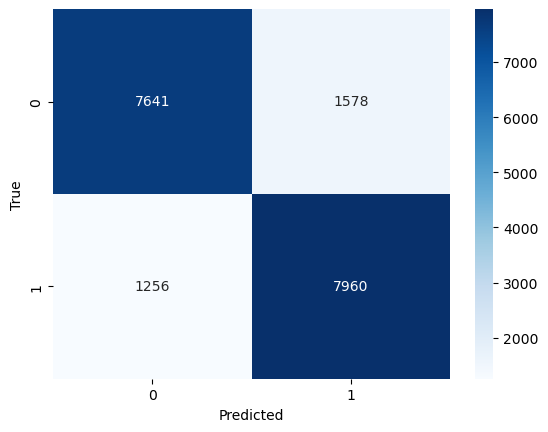

In [60]:
metricas(y_pred_nnw, y_test)

In [61]:
import joblib
joblib.dump(best_model, "neuralnetwork.joblib")

INFO:tensorflow:Assets written to: ram://1a1d36e8-daa5-4977-8bcd-1341c8e913c2/assets


['neuralnetwork.joblib']

In [65]:
best_model.model.save("test.pkl")

INFO:tensorflow:Assets written to: test.pkl/assets
